# Reading datasets forming a new one

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import poisson
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

directory = 'C:/Users/99451/Desktop/MODEL/eng_prem'

dfs = []

# Define the columns you want to extract from each CSV file
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A']

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename), on_bad_lines = 'skip', encoding='latin-1')
        df = df[columns_to_keep]
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
df.head()

Number of rows: 8214
Number of columns: 9


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,17/08/2002,Blackburn,Sunderland,0.0,0.0,D,1.727,3.25,4.333
1,17/08/2002,Charlton,Chelsea,2.0,3.0,A,2.800,3.25,2.200
2,17/08/2002,Everton,Tottenham,2.0,2.0,D,2.250,3.25,2.750
3,17/08/2002,Fulham,Bolton,4.0,1.0,H,1.727,3.25,4.333
4,17/08/2002,Leeds,Man City,3.0,0.0,H,1.667,3.40,4.500


# Adding Moving Averages

In [2]:
#Calculating Points Per Game for Home and Away Teams
df['HPTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [3, 1, 0], default=0)
df['APTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [0, 1, 3], default=0)

df['HPPG'] = df.groupby('HomeTeam')['HPTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['APPG'] = df.groupby('AwayTeam')['APTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating scored and conceded goals
df['FTHGS'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTHGC'] = df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['FTAGS'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTAGC'] = df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating odds probabilities
total = 1 / df['B365H'] + 1 / df['B365D'] + 1 / df['B365A']

df['FTH'] = (1 / df['B365H']) / total
df['FTD'] = (1 / df['B365D']) / total
df['FTA'] = (1 / df['B365A']) / total
df['FTDA'] = df['FTD'] + df['FTA']

# Calculate the league-wide moving average for home_goals and away_goals
df['league_home_goals'] = df['FTHG'].rolling(50, min_periods=1).mean().shift(1)
df['league_away_goals'] = df['FTAG'].rolling(50, min_periods=1).mean().shift(1)

#Calculating Poisson Statistics
df['home_attack'] = df['FTHGS'] / df['league_home_goals']
df['home_defence'] = df['FTHGC'] / df['league_away_goals']
df['away_attack'] = df['FTAGS'] / df['league_away_goals']
df['away_defence'] = df['FTAGC'] / df['league_home_goals']

df['home_xg'] = df['home_attack'] * df['away_defence'] * df['league_home_goals']
df['away_xg'] = df['away_attack'] * df['home_defence'] * df['league_away_goals']
df['xg_dif'] = df['home_xg'] - df['away_xg']

df.dropna(inplace = True)
df = df.reset_index(drop = True)

df['home_poisson'] = df['home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['away_poisson'] = df['away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['poisson_df'] = df['home_poisson'] - df['away_poisson']
df['FTRT'] = [1 if x == 'H' else 0 for x in df['FTR']]
df['form_dif'] = df['HPPG'] - df['APPG']

#Removing unnessary columns
df.drop(['Date', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A', 'HPTS', 'APTS', 'FTHGS', 'FTHGC', 'FTAGS', 'FTAGC',
            'FTD', 'FTA', 'league_home_goals', 'league_away_goals', 'home_attack', 'home_defence',
            'away_attack', 'away_defence', 'home_xg', 'away_xg', 'xg_dif'], axis = 1, inplace = True)



df[df['HomeTeam'] == 'Everton'].head(7)

,HomeTeam,AwayTeam,FTR,HPPG,APPG,FTH,FTDA,home_poisson,away_poisson,poisson_df,FTRT,form_dif
4,Everton,Birmingham,D,1.000000,0.000000,0.536974,0.463026,2,0,2,0,1.000000
31,Everton,Middlesbrough,H,1.000000,0.500000,0.389014,0.610986,0,0,0,1,0.500000
52,Everton,Fulham,H,1.666667,1.333333,0.398329,0.601671,1,2,-1,1,0.333333
69,Everton,Arsenal,H,2.000000,2.000000,0.162360,0.837640,1,2,-1,1,0.000000
103,Everton,Charlton,H,2.200000,0.800000,0.537421,0.462579,1,0,1,1,1.400000
121,Everton,West Brom,H,2.600000,0.800000,0.622124,0.377876,1,0,1,1,1.800000
142,Everton,Chelsea,A,3.000000,1.200000,0.359551,0.640449,0,0,0,0,1.800000


# Adding Points Table

In [3]:
#Creating Table According to Performance
point = 0
game = 0
teams = np.unique(df['HomeTeam'])

points = []
games = []
team_names = []

for team in teams:
    for j in range(len(df['HomeTeam'])):
        if team == df['HomeTeam'][j]:
            game += 1
            if df['FTR'][j] == 'H':
                point += 3
            elif df['FTR'][j] == 'D':
                point += 1
        elif team == df['AwayTeam'][j]:
            game += 1
            if df['FTR'][j] == 'A':
                point += 3
            elif df['FTR'][j] == 'D':
                point += 1
    points.append(point)
    team_names.append(team)
    games.append(game)
    point = 0
    ft_scored = 0
    ft_conceded = 0
    ht_scored = 0
    ht_conceded = 0
    game = 0


table = pd.DataFrame({
    'Teams': team_names,
    'Points': points,
    'Games': games,
})

table['PPG'] = table['Points'] / table['Games']
table = table.sort_values(by = 'PPG', ascending = False).reset_index(drop = True)
table

,Teams,Points,Games,PPG
0,Man United,1640,817,2.007344
1,Chelsea,1600,815,1.963190
2,Arsenal,1572,817,1.924113
3,Liverpool,1561,817,1.910649
4,Man City,1541,814,1.893120
5,Tottenham,1376,818,1.682152
6,Everton,1158,816,1.419118
7,Leicester,508,372,1.365591
8,Newcastle,956,740,1.291892
9,Blackburn,466,366,1.273224


In [4]:
# Create a dictionary mapping team names to their indices
team_indices = {team: index + 1 for index, team in enumerate(table['Teams'])}

# Create a dictionary mapping team names to points
team_points_dict = table.set_index('Teams')['PPG'].to_dict()

# Map points to home team in df_matches
df['HomePoints'] = df['HomeTeam'].map(team_points_dict)
df['AwayPoints'] = df['AwayTeam'].map(team_points_dict)

# Replace 'home' and 'away' team names with their indices from df2
df['HomeTeam'] = df['HomeTeam'].map(team_indices)
df['AwayTeam'] = df['AwayTeam'].map(team_indices)

df['Difference'] = df['AwayTeam'] - df['HomeTeam']
df['PpgDif'] = df['HomePoints'] - df['AwayPoints']

df.tail(10)

,HomeTeam,AwayTeam,FTR,HPPG,APPG,FTH,FTDA,home_poisson,away_poisson,poisson_df,FTRT,form_dif,HomePoints,AwayPoints,Difference,PpgDif
8138,9,6,H,1.8,1.2,0.351011,0.648989,2,2,0,1,0.6,1.291892,1.682152,-3,-0.390260
8139,12,36,H,0.6,0.8,0.662454,0.337546,1,2,-1,1,-0.2,1.242991,0.902778,24,0.340213
8140,30,15,D,1.0,0.8,0.271493,0.728507,0,2,-2,0,0.2,1.020896,1.214008,-15,-0.193112
8141,5,40,H,2.2,0.2,0.863636,0.136364,2,0,2,1,2.0,1.893120,0.806452,35,1.086669
8142,34,20,D,1.4,1.4,0.450928,0.549072,1,1,0,0,0.0,0.942029,1.171662,-14,-0.229633
8143,24,1,D,2.0,1.4,0.393939,0.606061,1,1,0,0,0.6,1.131783,2.007344,-23,-0.875561
8144,4,21,A,2.6,0.4,0.783728,0.216272,2,0,2,0,2.2,1.910649,1.147059,17,0.763590
8145,13,23,A,1.2,1.0,0.398230,0.601770,1,3,-2,0,0.2,1.237693,1.135823,10,0.101870
8146,3,11,A,3.0,2.0,0.738908,0.261092,2,1,1,0,1.0,1.924113,1.270270,8,0.653842
8147,2,7,H,2.0,0.4,0.560997,0.439003,2,0,2,1,1.6,1.963190,1.419118,5,0.544073


# Trying with Random Forest

c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set


Random Forest - Training Accuracy: 0.7809143909174593
Random Forest - Test Accuracy: 0.6404907975460122


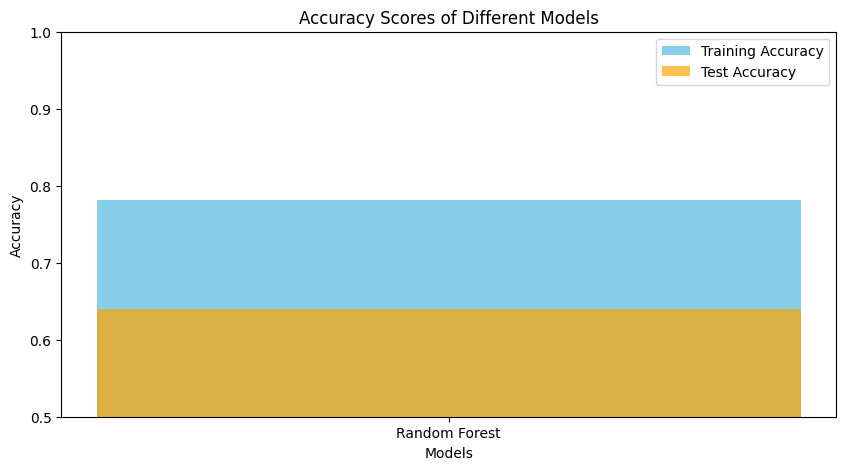

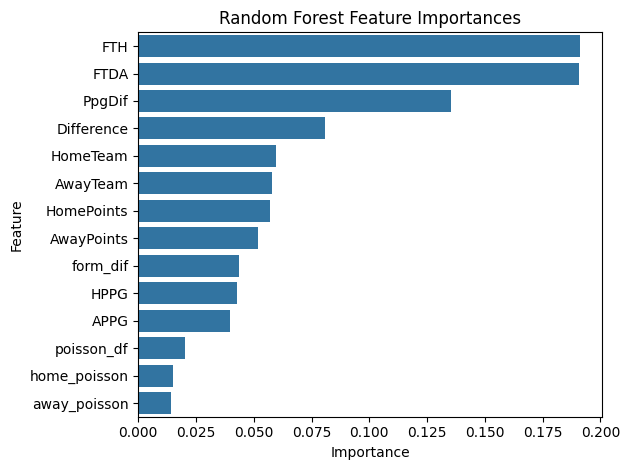

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       861
           1       0.62      0.63      0.62       769

    accuracy                           0.64      1630
   macro avg       0.64      0.64      0.64      1630
weighted avg       0.64      0.64      0.64      1630

Confusion Matrix:
[[562 299]
 [287 482]]
ROC AUC Score: 0.6397587104238124


In [5]:
# Split the data into training and testing sets
X = df.drop(columns=['FTRT', 'FTR'], axis = 1)  # Features
y = df['FTRT']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Random Forest
rf_model = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42)

# Train models
rf_model.fit(X_train, y_train)

# Predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

# Accuracy scores
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print("\nRandom Forest - Training Accuracy:", rf_train_accuracy)
print("Random Forest - Test Accuracy:", rf_test_accuracy)

rf_feature_importances = rf_model.feature_importances_

# Visualize accuracy scores
models = ['Random Forest']
train_accuracies = [rf_train_accuracy]
test_accuracies = [rf_test_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, train_accuracies, color='skyblue', label='Training Accuracy')
plt.bar(models, test_accuracies, color='orange', alpha=0.7, label='Test Accuracy')
plt.title('Accuracy Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.show()

# Visualize feature importances
rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

sns.barplot(x='Importance', y='Feature', data=rf_feature_importances_df.sort_values(by='Importance', ascending=False))
plt.title('Random Forest Feature Importances')

plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_test, rf_test_preds))

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, rf_test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, rf_test_preds)
print("ROC AUC Score:", roc_auc)

In [6]:
"""
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score

# Perform feature selection
model = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42,
                                        sampling_strategy = 'all', replacement = True, bootstrap = False)

for k in range(1, len(X_train.columns)):
    selector = SelectKBest(score_func=f_classif, k=k)  # Example: Select top 5 features
    X_selected = selector.fit_transform(X, y)
    # Evaluate model with cross-validation
    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='roc_auc')

    # Calculate average ROC AUC score
    avg_roc_auc = cv_scores.mean()
    print("Average ROC AUC score:", avg_roc_auc, 'and number of features: ', k)

X_selected = selector.fit_transform(X, y)

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Get names of selected features
selected_feature_names = X_train.columns[selected_indices]

print("Selected features:", selected_feature_names)

# Evaluate model with cross-validation
cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='roc_auc')

# Calculate average ROC AUC score
avg_roc_auc = cv_scores.mean()

print("Average ROC AUC score:", avg_roc_auc)
"""

'\nfrom sklearn.feature_selection import SelectKBest, f_classif\nfrom sklearn.model_selection import cross_val_score\n\n# Perform feature selection\nmodel = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42,\n                                        sampling_strategy = \'all\', replacement = True, bootstrap = False)\n\nfor k in range(1, len(X_train.columns)):\n    selector = SelectKBest(score_func=f_classif, k=k)  # Example: Select top 5 features\n    X_selected = selector.fit_transform(X, y)\n    # Evaluate model with cross-validation\n    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring=\'roc_auc\')\n\n    # Calculate average ROC AUC score\n    avg_roc_auc = cv_scores.mean()\n    print("Average ROC AUC score:", avg_roc_auc, \'and number of features: \', k)\n\nX_selected = selector.fit_transform(X, y)\n\n# Get indices of selected features\nselected_indices = selector.get_support(indices=True)\n\n# Ge

# Shallow Neural Network Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Assuming X_train and y_train are your training data and labels
# Assuming X_test and y_test are your testing data and labels

# Define the architecture of the shallow neural network
model = Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6320 - loss: 0.6576 - val_accuracy: 0.6250 - val_loss: 0.6322
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6499 - loss: 0.6291 - val_accuracy: 0.6518 - val_loss: 0.6244
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6568 - loss: 0.6316 - val_accuracy: 0.6518 - val_loss: 0.6377
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6554 - loss: 0.6306 - val_accuracy: 0.6564 - val_loss: 0.6210
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6479 - loss: 0.6299 - val_accuracy: 0.6296 - val_loss: 0.6391
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6440 - loss: 0.6293 - val_accuracy: 0.6472 - val_loss: 0.6445
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6586 - loss: 0.6200 - val_accuracy: 0.6587 - val_loss: 0.6173
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6564 - loss: 0.6193 - val_accuracy: 0.6488 - v

# Checking with LSTM

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential([
    LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences = True),  # LSTM layer with 50 units
    LSTM(units=32),
    Dense(units=1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6283 - loss: 0.6535
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6584 - loss: 0.6295
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6575 - loss: 0.6280
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6474 - loss: 0.6319
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6487 - loss: 0.6250
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6463 - loss: 0.6288
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6504 - loss: 0.6254
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6568 - loss: 0.6253
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6486 - loss: 0.6261
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6572 - loss: 0.6218
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6510 - loss: 0.6317
Epoch 12/100
102/102 ━━━━━━━━━

# Checking with RNN

In [9]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape = (X_train.shape[1], 1), return_sequences = True),  # 10 time steps, 1 input dimension
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/100


c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6611 - loss: 0.6336 - val_accuracy: 0.6488 - val_loss: 0.6229
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6539 - loss: 0.6261 - val_accuracy: 0.6350 - val_loss: 0.6396
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6556 - loss: 0.6198 - val_accuracy: 0.6442 - val_loss: 0.6316
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6439 - loss: 0.6351 - val_accuracy: 0.6534 - val_loss: 0.6364
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6684 - loss: 0.6184 - val_accuracy: 0.6304 - val_loss: 0.6404
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6650 - loss: 0.6207 - val_accuracy: 0.6580 - val_loss: 0.6180
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6723 - loss: 0.6117 - val_accuracy: 0.6495 - val_loss: 0.6227
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6658 - loss: 0.6132 - val_accuracy: 0.6480 - val_loss: 0.